This file is intended to process the original data and put out easily accesible data. 

The result should be two csv files:
    consumption.csv
    pv_production.csv

Both files should cover the same timespan.
The unit should be kWh/hh (kwH per half hour). Hence we can simply check how much energy is produced/consumed 
in a half hour timeframe.

    
+++ consumption.csv +++

Includes a certain number of consumers(houses) (e.g. 100) and the consumption rate for every half an hour.
The measurement started actually at different times in such a way, that the total overlap is less than a year. 
Hence take one year for each house. Starting at Jan-1 going until 31-DEC. 

TODO
LOOK AT DISTRIBUTION OF DF LENGTH


In [1]:
import pandas as pd
import glob
import sys
import natsort
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

## consumption.csv

In [2]:
# File paths
org_path = 'org_data/Power-Networks-LCL-June2015/'
org_files = glob.glob(org_path + '*.csv')
# Sort the files
org_files = natsort.natsorted(org_files)
print('Found: ' + str(len(org_files)) + ' files in org_path')
target_file = 'data/consumption.csv'

# Number of houses to find (should be less than len(org_files))
num_houses = 130

# Year that is just inserted that every one has same year
shared_year = 2020

Found: 150 files in org_path


In [3]:
# Get metrics for a single household from first file
# Create a dataframe where you can add the missing data
df = pd.read_csv(org_files[0])
# Drop first house since it might be incomplete
first_house_id = df['LCLid'].iloc[0]
df = df.where(df['LCLid'] != first_house_id).dropna()
# Choose only rows with second house
first_house_id = df['LCLid'].iloc[0]
df = df.where(df['LCLid'] == first_house_id).dropna()

# Drop duplicates according to datetime string
df.drop_duplicates('DateTime',inplace=True)

# Add a year column
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['year'] = [dt.year for dt in df['DateTime']]
cur_year = df['year'].iloc[0]

# Delete all rows that are not in the next year
df = df.where(df['year'] == cur_year+1).dropna()
df.drop(columns=['year'],inplace=True)
df['DateTime'] = [datetime(shared_year,dt.month,dt.day,hour=dt.hour,minute=dt.minute) for dt in df['DateTime']]

# Set DateTime as Index
df.index = pd.DatetimeIndex(df['DateTime'])

df['KWH/hh_0'] = df['KWH/hh (per half hour) ']
df.drop(columns=['stdorToU','Acorn','Acorn_grouped','KWH/hh (per half hour) ','LCLid'],inplace=True)
# Reindex to have all datetimes covered
idx = pd.date_range(start=str(shared_year)+'-01-01 00:00:00', end=str(shared_year)+'-12-31 23:30:00',freq='30T')
df = df.reindex(idx,fill_value=0)

df_store = df.copy()
df_store.head()

,DateTime,KWH/hh_0
2020-01-01 00:00:00,2020-01-01 00:00:00,1.966
2020-01-01 00:30:00,2020-01-01 00:30:00,1.9220001
2020-01-01 01:00:00,2020-01-01 01:00:00,1.808
2020-01-01 01:30:00,2020-01-01 01:30:00,0.795
2020-01-01 02:00:00,2020-01-01 02:00:00,1.235


In [4]:
# From each file take one house (the second house, since I think it is completly covered in the csv file)
org_files_reduced = org_files[1:num_houses]
# Counter for the building number
counter = 1
for org_file in org_files_reduced:
    df = pd.read_csv(org_file)
    # Drop the first house, because it might be incomplete
    first_house_id = df['LCLid'].iloc[0]
    df = df.where(df['LCLid'] != first_house_id).dropna()
    # Choose only rows with new first house
    first_house_id = df['LCLid'].iloc[0]
    df = df.where(df['LCLid'] == first_house_id).dropna()
    
    # Drop duplicates according to datetime string
    df.drop_duplicates('DateTime',inplace=True)
    
    # Add a year column
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['year'] = [dt.year for dt in df['DateTime']]
    cur_year = df['year'].iloc[0]
     
    # Delete all rows that are not in the next year
    df = df.where(df['year'] == cur_year+1).dropna()
    df.drop(columns=['year'],inplace=True)
    
    # Update year
    df['DateTime'] = [datetime(shared_year,dt.month,dt.day,hour=dt.hour,minute=dt.minute) for dt in df['DateTime']]
    
    # Set DateTime as Index
    df.index = pd.DatetimeIndex(df['DateTime'])
    
    # Reindex to 
    idx = pd.date_range(start=str(shared_year)+'-01-01 00:00:00', end=str(shared_year)+'-12-31 23:30:00',freq='30T')
    df = df.reindex(idx,fill_value=0)    
        
    # Append data from that house to another
    df_store['KWH/hh_'+str(counter)] = df['KWH/hh (per half hour) '].values
    counter += 1
            
print('Done')
print(df_store.head())

#Convert all entries to numeric values (Don't know where they got to strings before)
for key in df_store.keys():
    if key != 'DateTime':
        df_store[key] = pd.to_numeric(df_store[key])

df_store.to_csv(target_file)

Done
                               DateTime     KWH/hh_0 KWH/hh_1 KWH/hh_2  \
2020-01-01 00:00:00 2020-01-01 00:00:00       1.966        0     0.17    
2020-01-01 00:30:00 2020-01-01 00:30:00   1.9220001        0    0.098    
2020-01-01 01:00:00 2020-01-01 01:00:00       1.808        0    0.016    
2020-01-01 01:30:00 2020-01-01 01:30:00       0.795        0    0.011    
2020-01-01 02:00:00 2020-01-01 02:00:00       1.235        0     0.03    

                    KWH/hh_3 KWH/hh_4 KWH/hh_5 KWH/hh_6 KWH/hh_7 KWH/hh_8  \
2020-01-01 00:00:00   0.085    0.446     0.01    0.188    0.122    0.126    
2020-01-01 00:30:00   0.083    0.256    0.009    0.132    0.112    0.102    
2020-01-01 01:00:00   0.086     0.12    0.009    0.146     0.11    0.117    
2020-01-01 01:30:00   0.061    0.162    0.009    0.081    0.197    0.036    
2020-01-01 02:00:00   0.067    0.127     0.01    0.062    0.177    0.026    

                       ...     KWH/hh_120 KWH/hh_121 KWH/hh_122 KWH/hh_123  \
2020-01-0

In [5]:
# Test of loading the target file
df_load = pd.read_csv(target_file)
df_load['datetime'] = pd.to_datetime(df_load['DateTime'])
df_load.drop(columns=['Unnamed: 0','DateTime'],inplace=True)
df_load = df_load.set_index('datetime')
df_load.head()

,KWH/hh_0,KWH/hh_1,KWH/hh_2,KWH/hh_3,KWH/hh_4,KWH/hh_5,KWH/hh_6,KWH/hh_7,KWH/hh_8,KWH/hh_9,...,KWH/hh_120,KWH/hh_121,KWH/hh_122,KWH/hh_123,KWH/hh_124,KWH/hh_125,KWH/hh_126,KWH/hh_127,KWH/hh_128,KWH/hh_129
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,1.966,0.0,0.170,0.085,0.446,0.010,0.188,0.122,0.126,0.253,...,0.099,0.085,0.099,0.028,0.067,0.154,0.271,0,0.232,0.050
2020-01-01 00:30:00,1.922,0.0,0.098,0.083,0.256,0.009,0.132,0.112,0.102,0.157,...,0.265,0.086,0.076,0.005,0.070,0.217,0.279,0,0.168,0.018
2020-01-01 01:00:00,1.808,0.0,0.016,0.086,0.120,0.009,0.146,0.110,0.117,0.168,...,0.076,0.164,0.046,0.005,0.085,0.129,0.300,0,0.253,0.012
2020-01-01 01:30:00,0.795,0.0,0.011,0.061,0.162,0.009,0.081,0.197,0.036,0.148,...,0.201,0.259,0.037,0.005,0.067,0.158,0.460,0,0.141,0.053
2020-01-01 02:00:00,1.235,0.0,0.030,0.067,0.127,0.010,0.062,0.177,0.026,0.171,...,0.222,0.188,0.041,0.005,0.086,0.138,0.391,0,0.166,0.058


Text(0,0.5,'Average energy consumption')

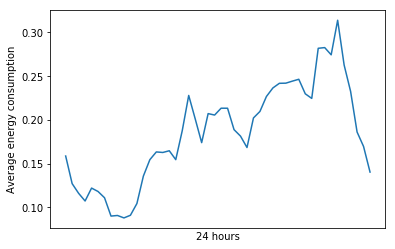

In [7]:
# Plot some test
plt.plot(df_load.index[48*150:48*151],df_load[48*150:48*151].mean(axis=1).values)
plt.xticks([])
plt.xlabel('24 hours')
plt.ylabel('Average energy consumption')